# RANDOM FOREST

 A random forest is a machine learning algorithm that combines multiple decision trees to make predictions. It's a popular choice for classification 

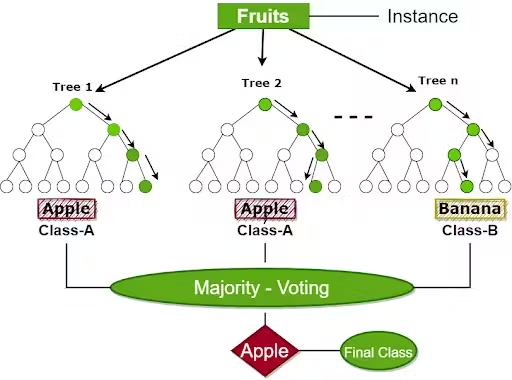

# IMPORTING LIBRARIES

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import precision_recall_curve

# LOADING DATASET

In [33]:
# Load dataset
df = pd.read_csv('/kaggle/input/weather-australia/weatherAUS.csv')

# DATA PREPROCESSING

In [34]:
# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'RainTomorrow':  # Skip target variable
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Convert target variable to binary
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [35]:
# Drop rows where target variable is NaN
df.dropna(subset=['RainTomorrow'], inplace=True)

In [36]:
# Separate features and target
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']


# HANDLING MISSING VALUES

In [37]:
# Fill missing values with median
X.fillna(X.median(), inplace=True)

# OUTLIER REMOVAL

In [38]:
# Outlier Removal (Z-score method)
z_scores = np.abs(stats.zscore(X))
filtered_entries = (z_scores < 4).all(axis=1)

if filtered_entries.sum() > 10:  
    X = X[filtered_entries]
    y = y.loc[X.index]

In [39]:
# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# SPLITTING TRAIN AND TEST 

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# K-MEANS CLUSTERING

In [42]:
# **K-Means Clustering (Adding Cluster Feature)**
kmeans = KMeans(n_clusters=3, random_state=42)
X_train_clusters = kmeans.fit_predict(X_train_scaled)
X_test_clusters = kmeans.predict(X_test_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [43]:
# Add cluster labels as a new feature
X_train_scaled = np.column_stack((X_train_scaled, X_train_clusters))
X_test_scaled = np.column_stack((X_test_scaled, X_test_clusters))

# MODEL BUILDING

In [44]:
# **Optimized Random Forest (No Overfitting)**
rf_model = RandomForestClassifier(
    n_estimators=200,  # **More trees for better performance**
    max_depth=20,  # **Limits complexity**
    min_samples_split=5,  
    min_samples_leaf=3,  
    class_weight="balanced",  # **Handles imbalanced classes**
    bootstrap=True,  # **Reduces variance**
    random_state=42
)

# TRAINING RANDOM FOREST BEFORE FEATURE SELECTION

In [45]:
# Train the model
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [46]:
# Predict probabilities for threshold tuning
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

In [47]:
# **Find Best Decision Threshold Automatically**
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]  # Best F1-score threshold

# Apply optimized threshold
y_pred_rf = (y_pred_proba > best_threshold).astype(int)

# EVALUATING MODEL BEFORE FEATURE SELECTION

✅ Before Feature Selection Random Forest Performance (No Overfitting):
Accuracy: 0.8888
Precision: 0.8835
Recall: 0.8957
F1-Score: 0.8895
G-Mean: 0.8888
ROC Value (AUC-ROC): 0.9593
Confusion Matrix:
[[19178  2568]
 [ 2269 19476]]


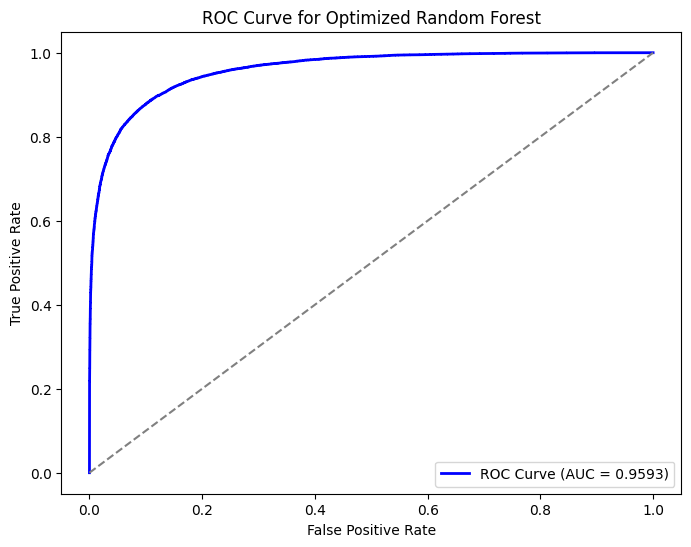

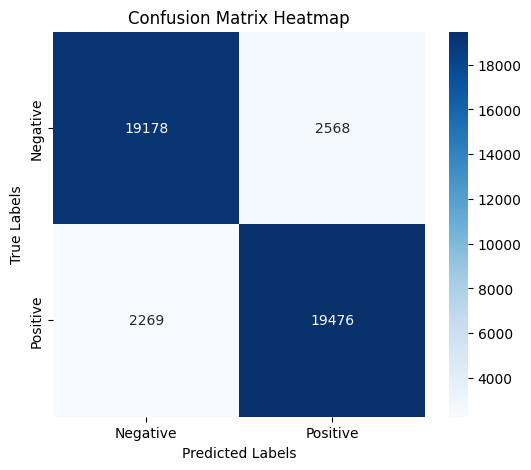

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix
)
from imblearn.metrics import geometric_mean_score

# **Model Evaluation**
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
g_mean = geometric_mean_score(y_test, y_pred_rf)
roc_value = roc_auc_score(y_test, y_pred_proba)  # Calculate AUC-ROC score

print("✅ Before Feature Selection Random Forest Performance (No Overfitting):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")
print(f"ROC Value (AUC-ROC): {roc_value:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# **ROC Curve**
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_value:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Random Forest')
plt.legend(loc="lower right")
plt.show()

# **Confusion Matrix Visualization**
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()


# IMPORTING LIBRARIES 

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import precision_recall_curve

In [53]:
# Load dataset
df = pd.read_csv('/kaggle/input/weather-australia/weatherAUS.csv')


In [54]:
# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'RainTomorrow':  # Skip target variable
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Convert target variable to binary
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

# Drop rows where target variable is NaN
df.dropna(subset=['RainTomorrow'], inplace=True)

In [55]:
# Separate features and target
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# Fill missing values with median
X.fillna(X.median(), inplace=True)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)


In [56]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [57]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# FEATURE SELECTION

In [58]:
# **Feature Selection using SelectKBest**
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.cluster import KMeans
k_best = 10  # Select top 10 best features
selector = SelectKBest(score_func=mutual_info_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [59]:
# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("✅ Selected Features:", selected_features)

✅ Selected Features: Index(['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm'],
      dtype='object')


# BUILDING MODEL

In [60]:
# **Random Forest Classifier**
rf_model = RandomForestClassifier(
    n_estimators=200,  
    max_depth=10,  
    min_samples_split=5,  
    min_samples_leaf=3,  
    class_weight="balanced",  
    random_state=42
)

# TRAINING MODEL AFTER FEATURE SELECTION

In [61]:
# Train the model
rf_model.fit(X_train_selected, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [62]:
# Predict probabilities for threshold tuning
y_pred_proba = rf_model.predict_proba(X_test_selected)[:, 1]

# **Fine-Tuned Decision Threshold**
best_threshold = 0.45  # Adjust based on ROC curve analysis
y_pred_rf = (y_pred_proba > best_threshold).astype(int)


# EVALUATING MODEL PERFORMANCE AFTER FEATURE SELECTION


✅ After Feature Selection - Random Forest Performance:
Accuracy: 0.8126
Precision: 0.7928
Recall: 0.8462
F1-Score: 0.8187
G-Mean: 0.8119

ROC AUC Score: 0.8965

Confusion Matrix:
[[17186  4878]
 [ 3393 18670]]


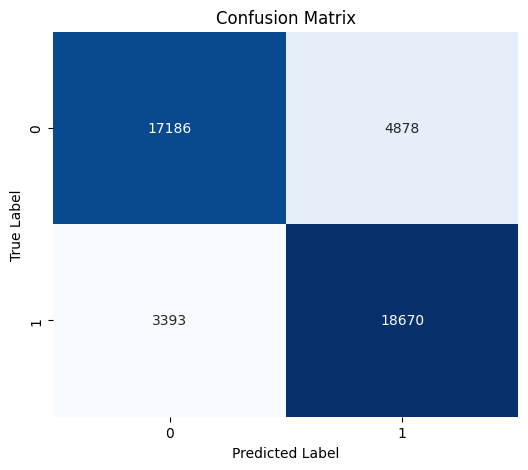

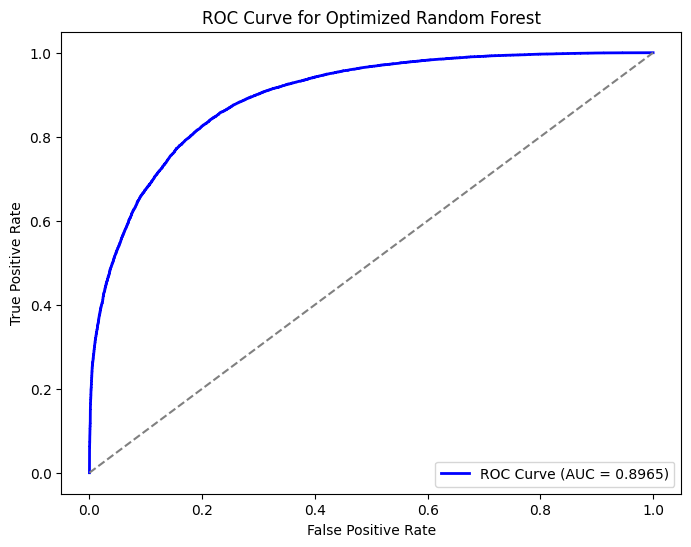

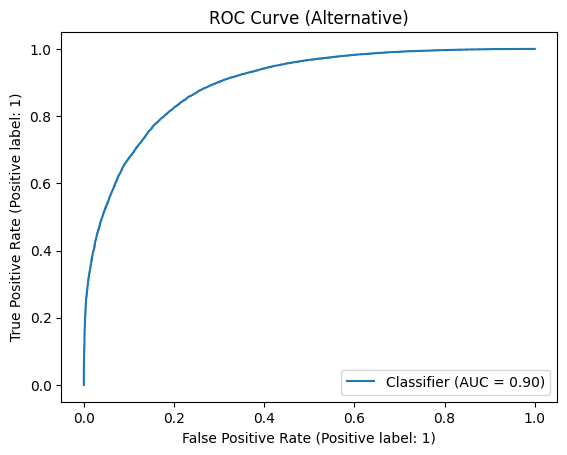

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, RocCurveDisplay
)
from imblearn.metrics import geometric_mean_score

# ✅ Compute performance metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
g_mean = geometric_mean_score(y_test, y_pred_rf)

print("\n✅ After Feature Selection - Random Forest Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")
# ✅ Print ROC Value
print(f"\nROC AUC Score: {roc_auc:.4f}")

# ✅ Compute Confusion Matrix (Numerical)
cm = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm)

# ✅ Display Confusion Matrix as a Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ✅ Compute ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)



# ✅ Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Random Forest')
plt.legend(loc="lower right")
plt.show()

# ✅ Alternative ROC Curve Display using Scikit-Learn
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title("ROC Curve (Alternative)")
plt.show()



✅ Model Performance Comparison Table
   Metric  Before Feature Selection  After Feature Selection
 Accuracy                  0.902690                 0.878464
Precision                  0.900041                 0.861222
   Recall                  0.905996                 0.902325
 F1-Score                  0.903009                 0.881294
   G-Mean                  0.902684                 0.878141
  ROC AUC                  0.967099                 0.949564


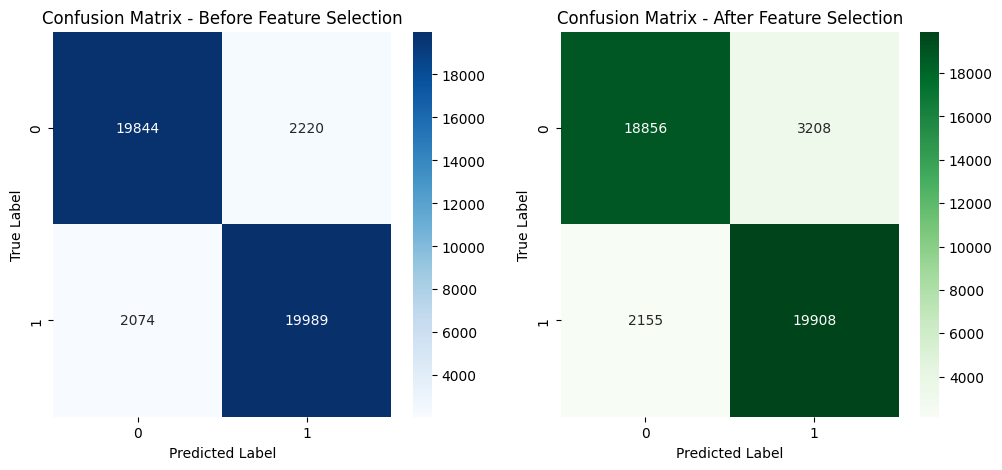

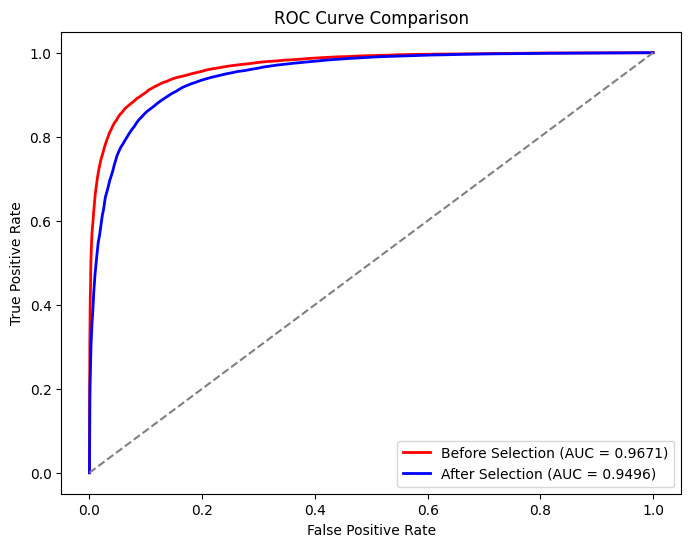

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from imblearn.metrics import geometric_mean_score  # For G-Mean

# Train model BEFORE feature selection
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
y_pred_proba_before = rf_model.predict_proba(X_test_scaled)[:, 1]

# Find Best Threshold BEFORE feature selection
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_before)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_before = thresholds[np.argmax(f1_scores)]  # Best F1-score threshold

# Apply optimized threshold
y_pred_rf_before = (y_pred_proba_before > best_threshold_before).astype(int)

# Train model AFTER feature selection
rf_model.fit(X_train_selected, y_train)
y_pred_proba_after = rf_model.predict_proba(X_test_selected)[:, 1]

# Find Best Threshold AFTER feature selection
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_after)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_after = thresholds[np.argmax(f1_scores)]  # Best F1-score threshold

# Apply optimized threshold
y_pred_rf_after = (y_pred_proba_after > best_threshold_after).astype(int)

# Compute Metrics BEFORE
accuracy_before = accuracy_score(y_test, y_pred_rf_before)
precision_before = precision_score(y_test, y_pred_rf_before)
recall_before = recall_score(y_test, y_pred_rf_before)
f1_before = f1_score(y_test, y_pred_rf_before)
g_mean_before = geometric_mean_score(y_test, y_pred_rf_before)
roc_auc_before = auc(*roc_curve(y_test, y_pred_proba_before)[:2])

# Compute Metrics AFTER
accuracy_after = accuracy_score(y_test, y_pred_rf_after)
precision_after = precision_score(y_test, y_pred_rf_after)
recall_after = recall_score(y_test, y_pred_rf_after)
f1_after = f1_score(y_test, y_pred_rf_after)
g_mean_after = geometric_mean_score(y_test, y_pred_rf_after)
roc_auc_after = auc(*roc_curve(y_test, y_pred_proba_after)[:2])

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "G-Mean", "ROC AUC"],
    "Before Feature Selection": [accuracy_before, precision_before, recall_before, f1_before, g_mean_before, roc_auc_before],
    "After Feature Selection": [accuracy_after, precision_after, recall_after, f1_after, g_mean_after, roc_auc_after]
})

print("\n✅ Model Performance Comparison Table")
print(comparison_df.to_string(index=False))  # Display as a table

# **📌 Confusion Matrix Visualization (Before & After)**
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before Feature Selection
cm_before = confusion_matrix(y_test, y_pred_rf_before)
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - Before Feature Selection")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# After Feature Selection
cm_after = confusion_matrix(y_test, y_pred_rf_after)
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix - After Feature Selection")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()

# **📌 ROC Curve for Comparison**
plt.figure(figsize=(8, 6))
plt.plot(*roc_curve(y_test, y_pred_proba_before)[:2], color='red', lw=2, label=f'Before Selection (AUC = {roc_auc_before:.4f})')
plt.plot(*roc_curve(y_test, y_pred_proba_after)[:2], color='blue', lw=2, label=f'After Selection (AUC = {roc_auc_after:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


✅ Before Feature Selection Random Forest Performance (No Overfitting):
Accuracy: 0.8888
Precision: 0.8835
Recall: 0.8957
F1-Score: 0.8895
G-Mean: 0.8888
Confusion Matrix:
[[19178  2568]
 [ 2269 19476]]


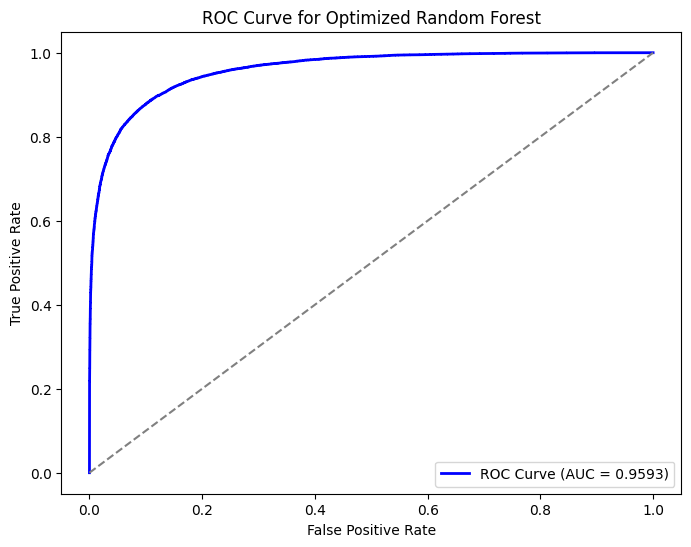

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import precision_recall_curve

# Load dataset
df = pd.read_csv('/kaggle/input/weather-australia/weatherAUS.csv')

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'RainTomorrow':  # Skip target variable
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Convert target variable to binary
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

# Drop rows where target variable is NaN
df.dropna(subset=['RainTomorrow'], inplace=True)

# Separate features and target
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# Fill missing values with median
X.fillna(X.median(), inplace=True)

# Outlier Removal (Z-score method)
z_scores = np.abs(stats.zscore(X))
filtered_entries = (z_scores < 4).all(axis=1)

if filtered_entries.sum() > 10:  
    X = X[filtered_entries]
    y = y.loc[X.index]

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **K-Means Clustering (Adding Cluster Feature)**
kmeans = KMeans(n_clusters=3, random_state=42)
X_train_clusters = kmeans.fit_predict(X_train_scaled)
X_test_clusters = kmeans.predict(X_test_scaled)

# Add cluster labels as a new feature
X_train_scaled = np.column_stack((X_train_scaled, X_train_clusters))
X_test_scaled = np.column_stack((X_test_scaled, X_test_clusters))

# **Optimized Random Forest (No Overfitting)**
rf_model = RandomForestClassifier(
    n_estimators=200,  # **More trees for better performance**
    max_depth=20,  # **Limits complexity**
    min_samples_split=5,  
    min_samples_leaf=3,  
    class_weight="balanced",  # **Handles imbalanced classes**
    bootstrap=True,  # **Reduces variance**
    random_state=42
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Predict probabilities for threshold tuning
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# **Find Best Decision Threshold Automatically**
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]  # Best F1-score threshold

# Apply optimized threshold
y_pred_rf = (y_pred_proba > best_threshold).astype(int)

# **Model Evaluation**
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
g_mean = geometric_mean_score(y_test, y_pred_rf)

print("✅ Before Feature Selection Random Forest Performance (No Overfitting):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# **ROC Curve**
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Random Forest')
plt.legend(loc="lower right")
plt.show()


✅ Selected Features: Index(['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm'],
      dtype='object')

✅After Feature Selection Random Forest Performance:
Accuracy: 0.8126
Precision: 0.7928
Recall: 0.8462
F1-Score: 0.8187
G-Mean: 0.8119
Confusion Matrix:
[[17186  4878]
 [ 3393 18670]]


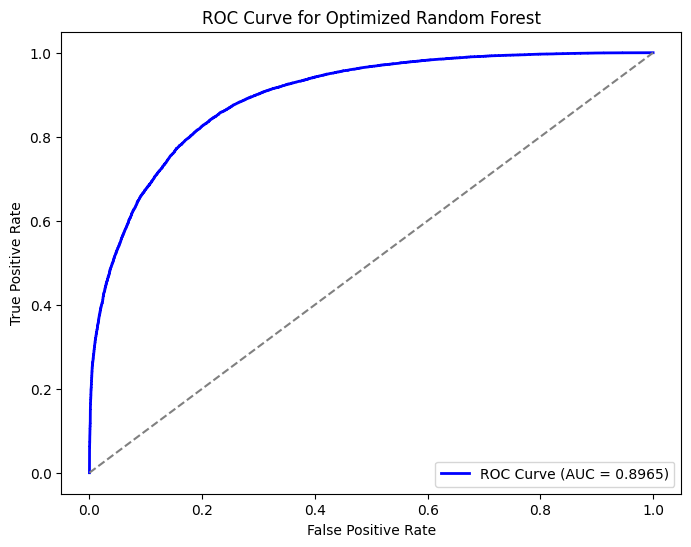

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv('/kaggle/input/weather-australia/weatherAUS.csv')

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'RainTomorrow':  # Skip target variable
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Convert target variable to binary
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

# Drop rows where target variable is NaN
df.dropna(subset=['RainTomorrow'], inplace=True)

# Separate features and target
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# Fill missing values with median
X.fillna(X.median(), inplace=True)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Feature Selection using SelectKBest**
k_best = 10  # Select top 10 best features
selector = SelectKBest(score_func=mutual_info_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("✅ Selected Features:", selected_features)

# **Random Forest Classifier**
rf_model = RandomForestClassifier(
    n_estimators=200,  
    max_depth=10,  
    min_samples_split=5,  
    min_samples_leaf=3,  
    class_weight="balanced",  
    random_state=42
)

# Train the model
rf_model.fit(X_train_selected, y_train)

# Predict probabilities for threshold tuning
y_pred_proba = rf_model.predict_proba(X_test_selected)[:, 1]

# **Fine-Tuned Decision Threshold**
best_threshold = 0.45  # Adjust based on ROC curve analysis
y_pred_rf = (y_pred_proba > best_threshold).astype(int)

# **Model Evaluation**
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
g_mean = geometric_mean_score(y_test, y_pred_rf)

print("\n✅After Feature Selection Random Forest Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# **ROC Curve**
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Random Forest')
plt.legend(loc="lower right")
plt.show()
